<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [29]:
# Check for GPU
!nvidia-smi

Der Befehl "nvidia-smi" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [30]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.2.2+cu118


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [31]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# data path
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


In [32]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [33]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [34]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"

test_dir, train_dir

(WindowsPath('data/pizza_steak_sushi/test'),
 WindowsPath('data/pizza_steak_sushi/train'))

In [35]:
import random
import pathlib
from PIL import Image


# Visualize an image
def visualize_rand_image(path):
    #paths of all images
    image_path_list = list(path.glob("*/*/*.jpg"))
    #pick an image at random
    rand_image_path = random.choice(image_path_list)
    # get image class name
    image_class_name = rand_image_path.parent.stem

    # Open image
    img = Image.open(rand_image_path)

    # show image and print data
    print(f"Random image path: {rand_image_path}\n Image class name: {image_class_name}")
    print(f"Image height: {img.height}, Image width: {img.width}")
    return img, image_class_name

Random image path: data\pizza_steak_sushi\train\steak\1839481.jpg
 Image class name: steak
Image height: 512, Image width: 512


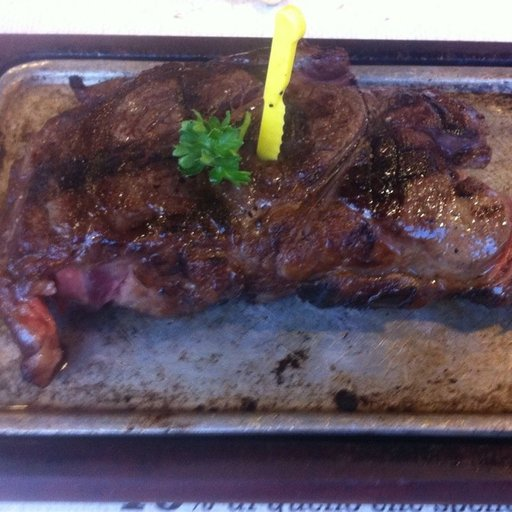

In [36]:
img, img_class = visualize_rand_image(image_path)
img

(-0.5, 511.5, 511.5, -0.5)

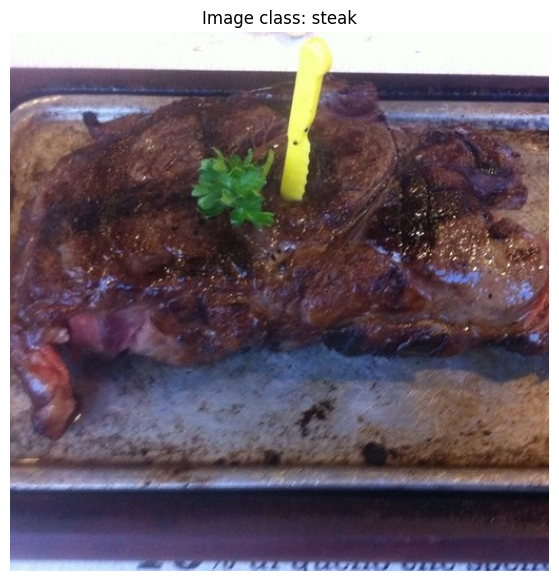

In [37]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {img_class}")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [38]:
# 3.1 Transforming data with torchvision.transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [39]:
# Write transform for turning images into tensors
data_transformed = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.RandomAdjustSharpness(1.2),
    transforms.ToTensor()
])

In [40]:
# Write a function to plot transformed images
def plot_transformed_images(img_paths, transform, n=5, seed=42):
    """
    img_paths(list): List of target paths
    transform: image to tensor transform
    n: how many pictures should be plotted
    seed: random seed to replicate

    output: plot of image vs transformed images
    """
    #random.seed(seed)
    random_image_paths = random.sample(img_paths, n)
    for image in random_image_paths:
        with Image.open(image) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # now the transformed image
            #pytorch default is [C, H, W] matplotlib is [H, W, C]
            transformed_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Original \nSize: {transformed_img.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


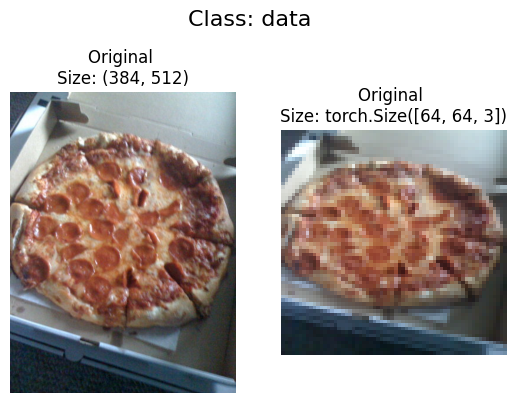

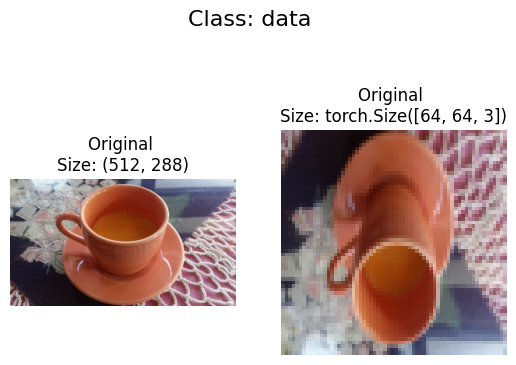

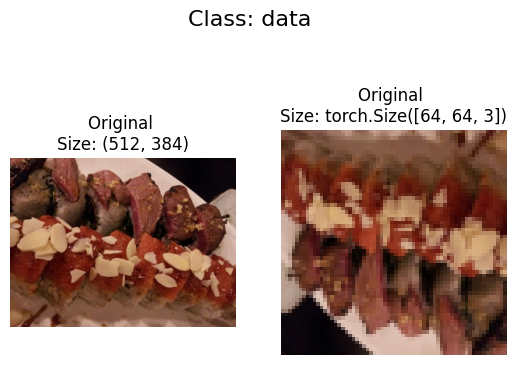

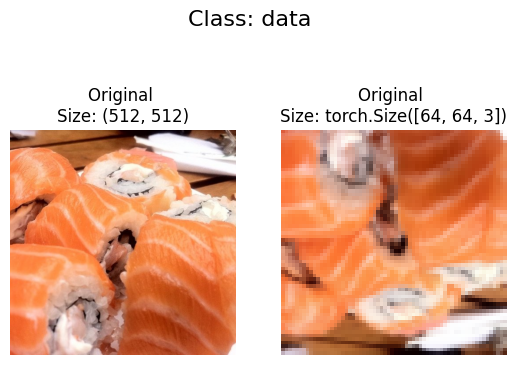

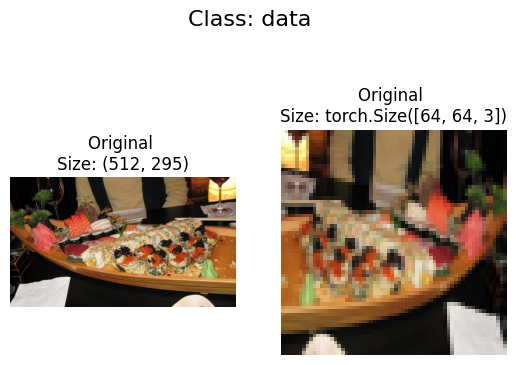

In [41]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(image_path_list, data_transformed)

### Load image data using `ImageFolder`

In [42]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transformed,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transformed)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomGrayscale(p=0.5)
               RandomAdjustSharpness(sharpness_factor=1.2,p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomGrayscale(p=0.5)
               RandomAdjustSharpness(sharpness_factor=1.2,p=0.5)
               ToTensor()
           )


In [43]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [44]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [45]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [46]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              shuffle=True,
                              num_workers=1)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1d9238c9a50>,
 <torch.utils.data.dataloader.DataLoader at 0x1d92391d990>)

In [47]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [48]:
simple_tranform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_tranform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_tranform)

BATCH_SIZE = 32
NUM_WOKERS = os.cpu_count()
print(NUM_WOKERS)

#create DataLoaders
train_dataloader_simple = DataLoader(train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WOKERS)
test_dataloader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WOKERS)

train_dataloader_simple, test_dataloader_simple

12


(<torch.utils.data.dataloader.DataLoader at 0x1d92273c710>,
 <torch.utils.data.dataloader.DataLoader at 0x1d92273f210>)

In [49]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [50]:
model_0 = TinyVGG(3, 10, len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [51]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  
  return train_loss, train_acc

In [52]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)
      # 1. Forward pass

      test_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  
  return test_loss, test_acc

In [53]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [54]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [28]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_5 = TinyVGG(3, 10, len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

#Train the model
model_5_results_5 = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, NUM_EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1061 | train_acc: 0.2461 | test_loss: 1.1109 | test_acc: 0.2812
Epoch: 2 | train_loss: 1.0779 | train_acc: 0.5664 | test_loss: 1.1302 | test_acc: 0.2292
Epoch: 3 | train_loss: 1.0955 | train_acc: 0.3008 | test_loss: 1.1350 | test_acc: 0.3021
Epoch: 4 | train_loss: 1.0584 | train_acc: 0.4180 | test_loss: 1.1056 | test_acc: 0.3021
Epoch: 5 | train_loss: 1.0330 | train_acc: 0.4453 | test_loss: 1.0860 | test_acc: 0.3333


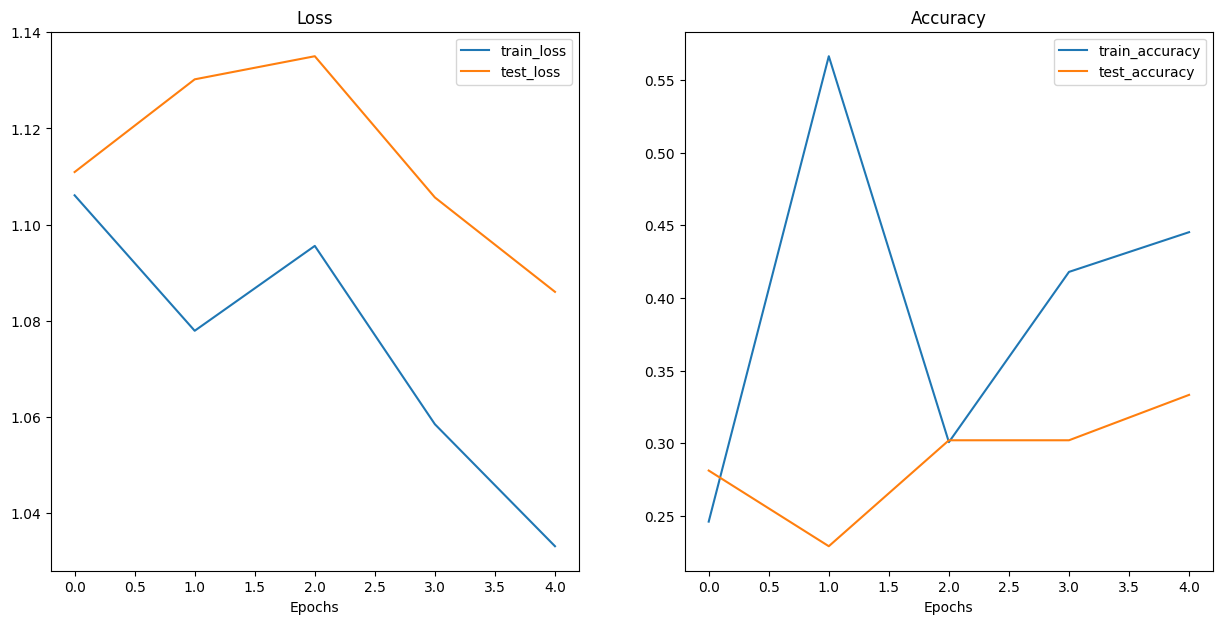

In [29]:
plot_loss_curves(model_5_results_5)

In [30]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

model_20 = TinyVGG(3, 10, len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

#Train the model
model_20_results_20 = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9067 | train_acc: 0.6133 | test_loss: 1.0714 | test_acc: 0.3513
Epoch: 2 | train_loss: 1.0548 | train_acc: 0.4805 | test_loss: 1.0013 | test_acc: 0.4138
Epoch: 3 | train_loss: 0.9217 | train_acc: 0.5430 | test_loss: 1.0787 | test_acc: 0.4659
Epoch: 4 | train_loss: 0.8250 | train_acc: 0.6523 | test_loss: 0.9931 | test_acc: 0.4138
Epoch: 5 | train_loss: 0.8468 | train_acc: 0.6758 | test_loss: 1.0517 | test_acc: 0.4347
Epoch: 6 | train_loss: 0.8582 | train_acc: 0.5312 | test_loss: 1.0964 | test_acc: 0.3930
Epoch: 7 | train_loss: 0.8821 | train_acc: 0.5352 | test_loss: 0.9777 | test_acc: 0.4725
Epoch: 8 | train_loss: 0.7601 | train_acc: 0.6328 | test_loss: 0.9566 | test_acc: 0.4735
Epoch: 9 | train_loss: 0.8033 | train_acc: 0.6953 | test_loss: 0.9969 | test_acc: 0.3930
Epoch: 10 | train_loss: 0.7265 | train_acc: 0.7031 | test_loss: 0.9280 | test_acc: 0.5028
Epoch: 11 | train_loss: 0.7305 | train_acc: 0.6836 | test_loss: 0.9928 | test_acc: 0.4545
Epoch: 12 | train_l

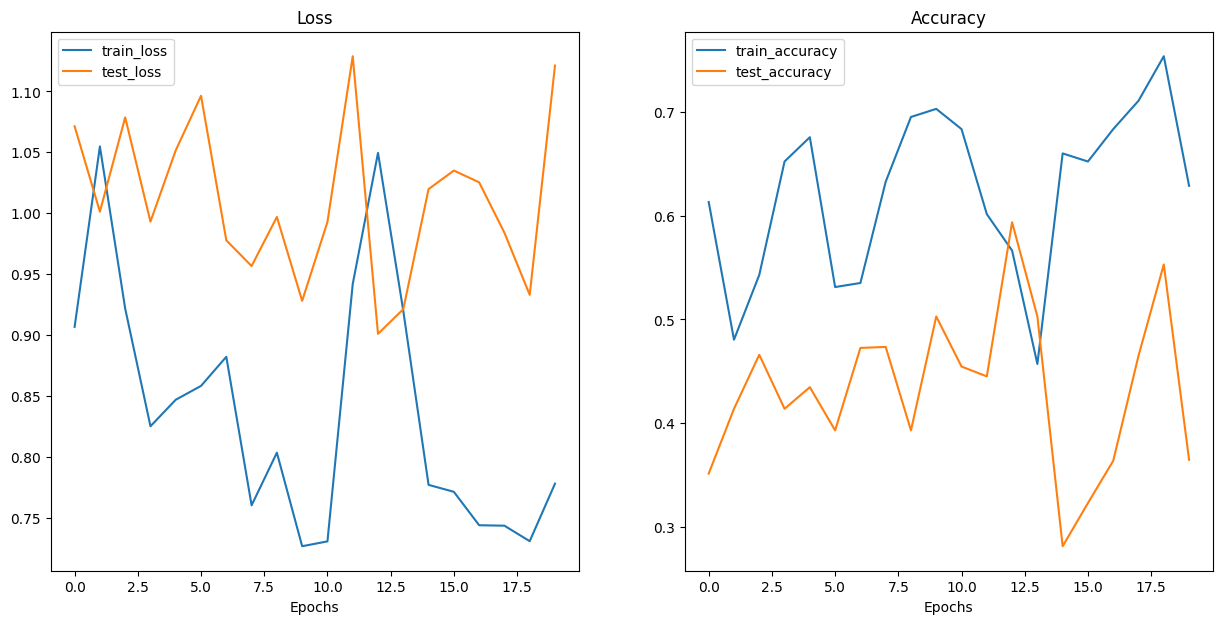

In [31]:
plot_loss_curves(model_20_results_20)

In [32]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 50

model_0 = TinyVGG(3, 10, len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

#Train the model
model_50_results_50 = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0964 | train_acc: 0.3125 | test_loss: 1.1486 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1185 | train_acc: 0.3281 | test_loss: 1.1419 | test_acc: 0.3125
Epoch: 8 | train_loss: 1.1008 | train_acc: 0.3633 | test_loss: 1.1038 | test_acc: 0.2188
Epoch: 9 | train_loss: 1.0877 | train_acc: 0.5039 | test_loss: 1.0639 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.0650 | train_acc: 0.4023 | test_loss: 1.0144 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.0402 | train_acc: 0.4258 | test_loss: 0.9756 | test_acc: 0.6042
Epoch: 12 | train_l

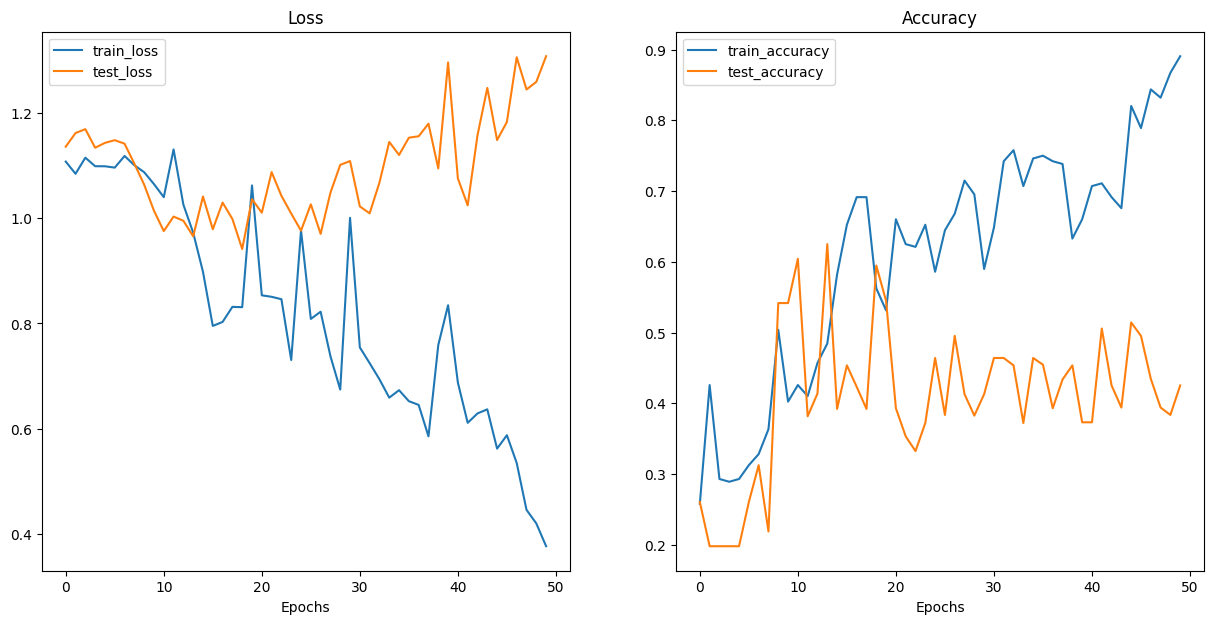

In [33]:
plot_loss_curves(model_50_results_50)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [34]:
# Double the number of hidden units and train for 20 epochs

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

model_0 = TinyVGG(3, 20, len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

#Train the model
model_2020_results_2020 = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.4180 | test_loss: 1.1061 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1267 | train_acc: 0.3047 | test_loss: 1.1017 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0949 | train_acc: 0.3125 | test_loss: 1.0969 | test_acc: 0.3949
Epoch: 4 | train_loss: 1.0927 | train_acc: 0.4258 | test_loss: 1.0716 | test_acc: 0.5843
Epoch: 5 | train_loss: 1.0473 | train_acc: 0.5547 | test_loss: 1.0394 | test_acc: 0.5057
Epoch: 6 | train_loss: 0.9702 | train_acc: 0.5391 | test_loss: 1.1707 | test_acc: 0.3125
Epoch: 7 | train_loss: 1.0464 | train_acc: 0.4648 | test_loss: 0.9217 | test_acc: 0.5227
Epoch: 8 | train_loss: 0.9021 | train_acc: 0.5898 | test_loss: 1.1023 | test_acc: 0.3333
Epoch: 9 | train_loss: 0.8977 | train_acc: 0.4805 | test_loss: 0.9939 | test_acc: 0.4044
Epoch: 10 | train_loss: 0.9539 | train_acc: 0.5195 | test_loss: 0.9726 | test_acc: 0.4934
Epoch: 11 | train_loss: 0.9117 | train_acc: 0.5664 | test_loss: 0.9987 | test_acc: 0.3731
Epoch: 12 | train_l

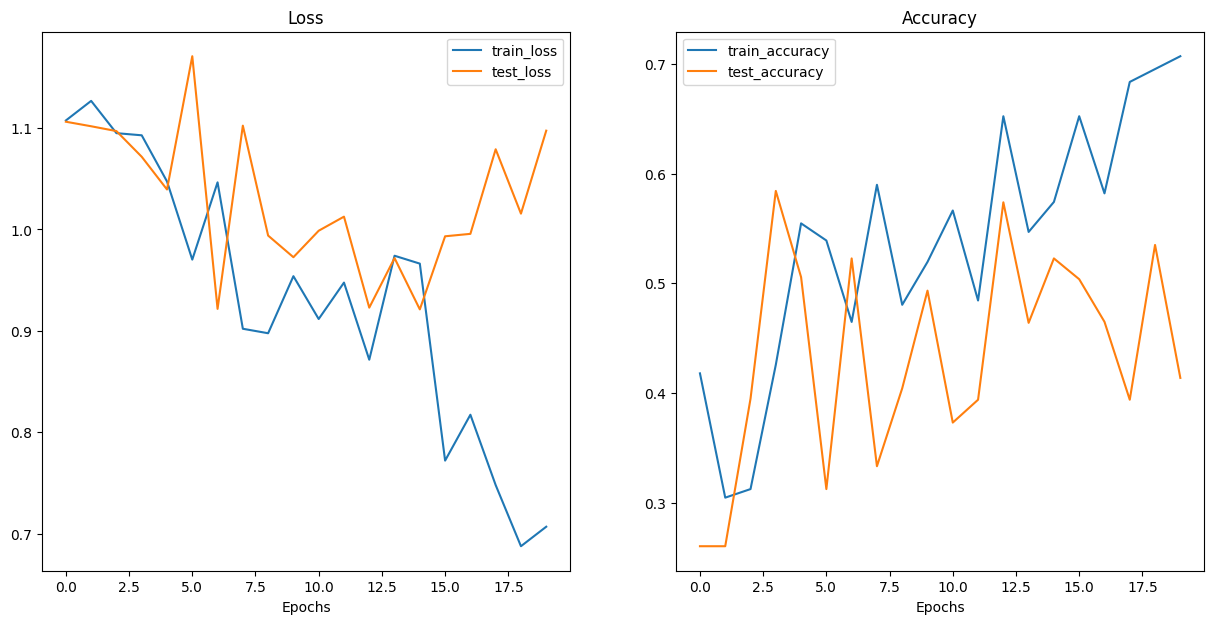

In [35]:
plot_loss_curves(model_2020_results_2020)

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [55]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data\pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [56]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [57]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [58]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])


# Create datasets
train_data_20_percent_simple = ImageFolder(root=train_data_20_percent_path, transform=simple_tranform, target_transform=None)
test_data_20_percent_simple = ImageFolder(root=test_data_20_percent_path, transform=simple_tranform)

# Create dataloaders
train_20_percent_dataloader = DataLoader(dataset=train_data_20_percent_simple,
                                         batch_size=1,
                                         num_workers=1,
                                         shuffle=True
                                         )
test_20_percent_dataloader = DataLoader(dataset=test_data_20_percent_simple,
                                         batch_size=1,
                                         num_workers=1
                                         )

In [40]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 50

model_20_percent = TinyVGG(3, 20, len(train_data_20_percent_simple.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_20_percent.parameters(), 
                             lr=0.001)

model_20_percent_results = train(model_20_percent, train_20_percent_dataloader, test_20_percent_dataloader, optimizer, loss_fn, NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1191 | train_acc: 0.3178 | test_loss: 1.0993 | test_acc: 0.3067
Epoch: 2 | train_loss: 1.0991 | train_acc: 0.3422 | test_loss: 1.0994 | test_acc: 0.3067
Epoch: 3 | train_loss: 1.0992 | train_acc: 0.3422 | test_loss: 1.0995 | test_acc: 0.3067
Epoch: 4 | train_loss: 1.0992 | train_acc: 0.3422 | test_loss: 1.1002 | test_acc: 0.3067
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3422 | test_loss: 1.1003 | test_acc: 0.3067
Epoch: 6 | train_loss: 1.0991 | train_acc: 0.3311 | test_loss: 1.1005 | test_acc: 0.3067
Epoch: 7 | train_loss: 1.0991 | train_acc: 0.3133 | test_loss: 1.1008 | test_acc: 0.3067
Epoch: 8 | train_loss: 1.0990 | train_acc: 0.3356 | test_loss: 1.1011 | test_acc: 0.3067
Epoch: 9 | train_loss: 1.1021 | train_acc: 0.3444 | test_loss: 1.1009 | test_acc: 0.3067
Epoch: 10 | train_loss: 1.0993 | train_acc: 0.3422 | test_loss: 1.1011 | test_acc: 0.3067
Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3422 | test_loss: 1.1014 | test_acc: 0.3067
Epoch: 12 | train_l

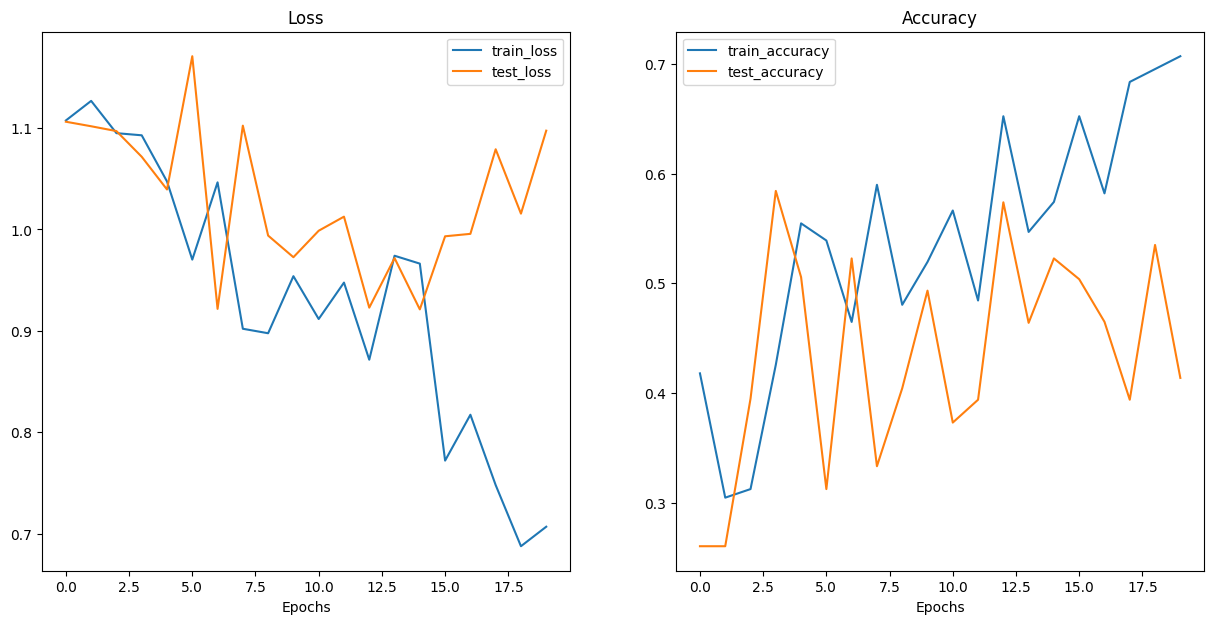

In [41]:
plot_loss_curves(model_2020_results_2020)

# More Complex transformation

In [59]:
# Write transform for turning images into tensors
complex_transfo = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.RandomAdjustSharpness(1.2),
    transforms.ToTensor()
])

# Create datasets
train_data_20_percent_complex = ImageFolder(root=train_data_20_percent_path, transform=complex_transfo, target_transform=None)
test_data_20_percent_complex = ImageFolder(root=test_data_20_percent_path, transform=complex_transfo)

# Create dataloaders
train_20_percent_dataloader_complex = DataLoader(dataset=train_data_20_percent_complex,
                                         batch_size=1,
                                         num_workers=1,
                                         shuffle=True
                                         )
test_20_percent_dataloader_complex = DataLoader(dataset=test_data_20_percent_complex,
                                         batch_size=1,
                                         num_workers=1
                                         )

In [43]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 50

model_20_percent = TinyVGG(3, 20, len(train_data_20_percent_complex.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_20_percent.parameters(), 
                             lr=0.001)

model_20_percent_results = train(model_20_percent, train_20_percent_dataloader_complex, test_20_percent_dataloader_complex, optimizer, loss_fn, NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3756 | test_loss: 1.0621 | test_acc: 0.4000
Epoch: 2 | train_loss: 1.0278 | train_acc: 0.4889 | test_loss: 0.9093 | test_acc: 0.5933
Epoch: 3 | train_loss: 0.9498 | train_acc: 0.5756 | test_loss: 0.9785 | test_acc: 0.5400
Epoch: 4 | train_loss: 0.9428 | train_acc: 0.5111 | test_loss: 0.8886 | test_acc: 0.5600
Epoch: 5 | train_loss: 0.9062 | train_acc: 0.5889 | test_loss: 0.9360 | test_acc: 0.5200
Epoch: 6 | train_loss: 0.9083 | train_acc: 0.5867 | test_loss: 0.9089 | test_acc: 0.5267
Epoch: 7 | train_loss: 0.8948 | train_acc: 0.5800 | test_loss: 0.9298 | test_acc: 0.5333
Epoch: 8 | train_loss: 0.9037 | train_acc: 0.5622 | test_loss: 0.9005 | test_acc: 0.5933
Epoch: 9 | train_loss: 0.8947 | train_acc: 0.5667 | test_loss: 0.9656 | test_acc: 0.6000
Epoch: 10 | train_loss: 0.9205 | train_acc: 0.5289 | test_loss: 0.9007 | test_acc: 0.6133
Epoch: 11 | train_loss: 0.8643 | train_acc: 0.5889 | test_loss: 0.8487 | test_acc: 0.5933
Epoch: 12 | train_l

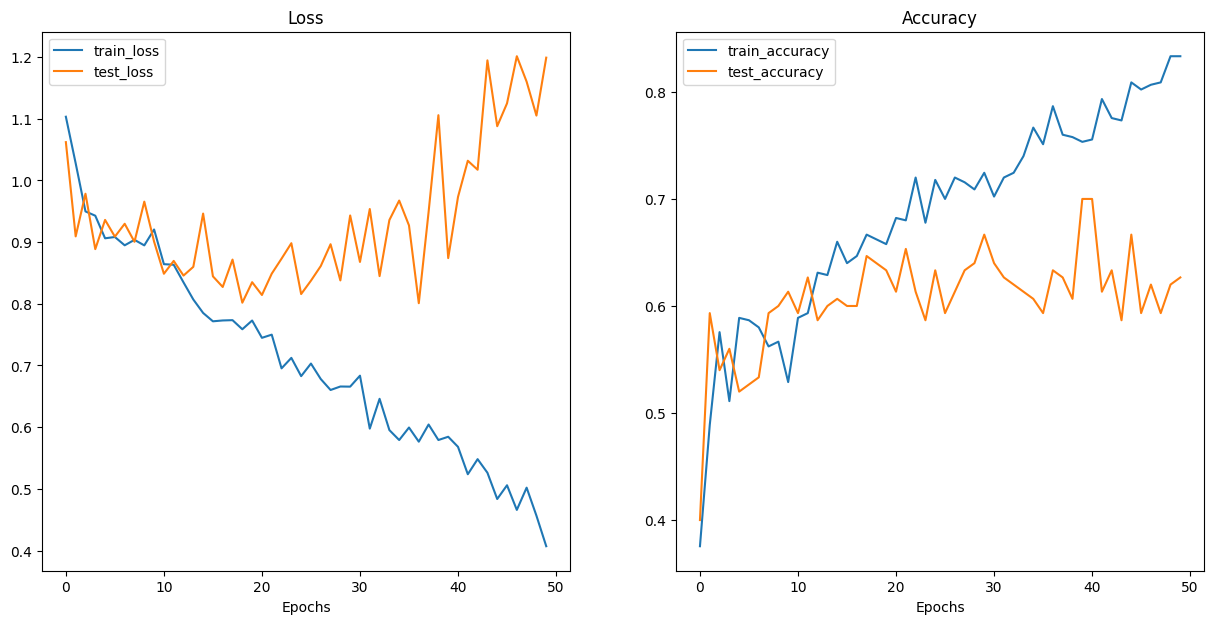

In [44]:
plot_loss_curves(model_20_percent_results)

# save the 20 percent model

In [60]:
# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "20_percent_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_20_percent.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\20_percent_model.pth


In [61]:
MODEL_PATH = Path("models")
# Create model save path
MODEL_NAME = "20_percent_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = TinyVGG(3, 20, len(train_data_20_percent_complex.classes))

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [55]:
data_path = Path("data/")
custom_image1 = data_path/"steak1.jpeg"
custom_image2 = data_path/"steak2.jpeg"


Image.open(custom_image1)
#img1 = torchvision.io.read_image(custom_image1)
#img1

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dtimo\\Documents\\GitHub\\pytorch-deep-learning\\extras\\exercises\\data\\steak1.jpeg'

In [58]:
custom_image = "steak1.jpeg"
img = torchvision.io.read_image(custom_image)
img

RuntimeError: [Errno 2] No such file or directory: 'steak1.jpg'